In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error

from models import AR_LSTM, compile_and_fit_tf


2023-05-11 16:02:41.393694: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### data setup

In [3]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [4]:
area = "city of london"
monthly_data = utils.load_interpolated_data()

area_data = utils.get_area(monthly_data, area)


In [5]:
def plot_inputs_outputs(area_data,
                        ground_truth,
                        train_ts,
                        test_ts,
                        cols,
                        col_idx,
                        lookback,
                        lookforward,
                        fwd_offset,
                        title=''):
    """ Args: 
            area_data: dataframe containing dates
            ground_truth: dataframe containing ground truth data
            train_ts: np array containing time series in the shape 
                (n_samples, lookback timesteps, n_features)
            test_ts: np array containing time series in the shape 
                (n_samples, lookforward timesteps, n_features)
            cols (str list): list of strings of features 
            col_idx (int): index of the feature to be plotted 
            lookback (int): number of timesteps in the lookback 
            lookforward (int): number of timesteps in the lookforward
            fwd_idx (int): which forward prediction/sample to plot
            title (str)
    """
    # fwd_idx = fwd_idx % lookforward
    col = cols[col_idx]
    plt.plot(area_data.date, ground_truth[col])
    plt.plot(area_data.date[range(lookback, lookback + len(train_ts))],
             train_ts[:, col_idx])
    plt.plot(
        area_data.date[range(
            lookback * 2 + fwd_offset + lookforward + len(train_ts),
            lookback * 2 + fwd_offset + lookforward + len(train_ts) +
            len(test_ts))], test_ts[:, col_idx])
    plt.title(title)

In [6]:
def plot_cumulative(area_data,
                    ground_truth_diff,
                    train_ts_diff,
                    test_ts_diff,
                    cols,
                    col_idx,
                    lookback,
                    lookforward,
                    fwd_offset=0,
                    title=''):
    init_train_offset = area_data.loc[lookback, 'average_price']
    init_test_offset = area_data.loc[lookback * 2 + fwd_offset + lookforward +
                                     len(train_ts_diff), 'average_price']
    plot_inputs_outputs(
        area_data,
        np.cumsum(ground_truth_diff) + init_train_offset,
        np.cumsum(train_ts_diff).reshape(-1, 1) + init_train_offset,
        np.cumsum(test_ts_diff).reshape(-1, 1) + init_test_offset, cols,
        col_idx, lookback, lookforward, fwd_offset, title)


## single-step prediction

### predict raw price

#### data setup

In [7]:
cols = ["average_price"]
lookback = 12
lookforward = 1
train_df, test_df, X_train, y_train, X_test, y_test, scaler = utils.format_data_for_forecasting(
    area_data, cols, lookback, lookforward)

In [8]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(197, 12, 1)
(197, 1, 1)
(78, 12, 1)
(78, 1, 1)


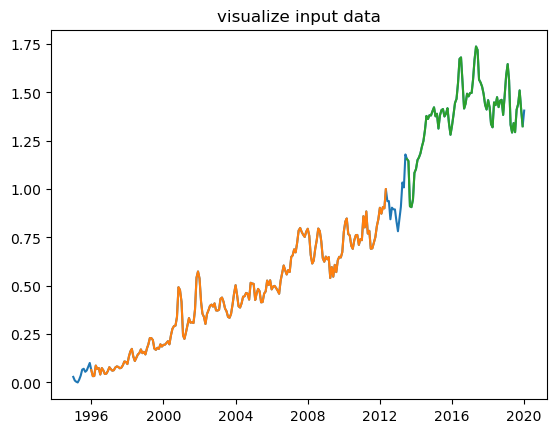

In [9]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [10]:
ar_lstm_model = AR_LSTM(
    units=64,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_lstm_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=50,
                             patience=10)


2023-05-11 16:03:02.369301: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
7/7 [==============================] - 4s 127ms/step - loss: 0.1382 - mean_absolute_error: 0.3143 - val_loss: 0.4327 - val_mean_absolute_error: 0.6482
Epoch 2/50
7/7 [==============================] - 0s 28ms/step - loss: 0.0223 - mean_absolute_error: 0.1154 - val_loss: 0.0147 - val_mean_absolute_error: 0.0999
Epoch 3/50
7/7 [==============================] - 0s 21ms/step - loss: 0.0189 - mean_absolute_error: 0.1250 - val_loss: 0.0151 - val_mean_absolute_error: 0.1001
Epoch 4/50
7/7 [==============================] - 0s 21ms/step - loss: 0.0076 - mean_absolute_error: 0.0729 - val_loss: 0.0933 - val_mean_absolute_error: 0.2879
Epoch 5/50
7/7 [==============================] - 0s 19ms/step - loss: 0.0087 - mean_absolute_error: 0.0714 - val_loss: 0.0645 - val_mean_absolute_error: 0.2328
Epoch 6/50
7/7 [==============================] - 0s 24ms/step - loss: 0.0057 - mean_absolute_error: 0.0599 - val_loss: 0.0193 - val_mean_absolute_error: 0.1156
Epoch 7/50
7/7 [=================

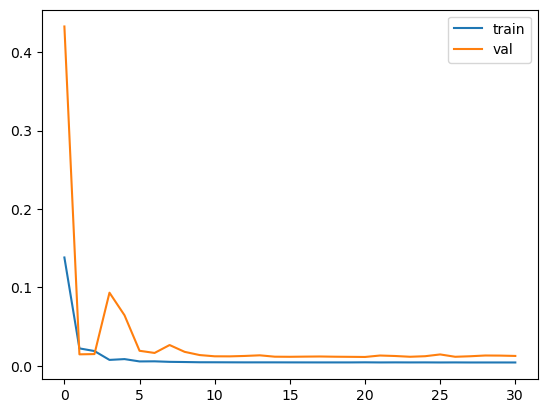

In [11]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('epochs')
plt.ylabel('MSE loss')
plt.title('Train and Validation Loss by Epoch')
plt.legend()

#### predictions

In [12]:
pred_train = ar_lstm_model.predict(X_train)  #[:, -1]
pred_test = ar_lstm_model.predict(X_test)  #[:, -1]

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])

3/3 [==============================] - 0s 5ms/step


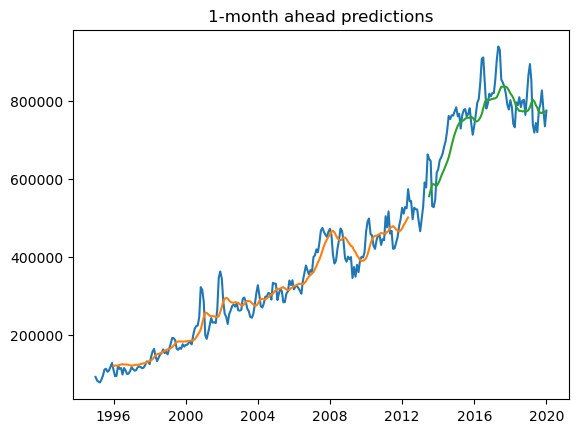

In [13]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='1-month ahead predictions')


In [14]:
y_1mo_train_rescaled = scaler.inverse_transform(y_train[:, 0])
y_1mo_test_rescaled = scaler.inverse_transform(y_test[:, 0])

In [15]:
y_1mo_train_rescaled.shape

(197, 1)

In [16]:
print('Train 1mo RMSE: {}'.format(
    np.sqrt(mean_squared_error(pred_1mo_train_rescaled, y_1mo_train_rescaled))))
print('Test 1mo RMSE: {}'.format(
    np.sqrt(mean_squared_error(pred_1mo_test_rescaled, y_1mo_test_rescaled))))

Train 1mo RMSE: 32552.016164293575
Test 1mo RMSE: 55918.74061765498


### multiple features

#### data

In [17]:
cols = [
    'average_price', 'year', 'month', 'average_price_d1', 'median_salary',
    'population_size', 'number_of_jobs', 'no_of_houses'
]  # w no nans

lookback = 12
lookforward = 1
train_df, test_df, X_train, y_train, X_test, y_test, scaler = utils.format_data_for_forecasting(
    area_data, cols, lookback, lookforward)

In [18]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(197, 12, 8)
(197, 1, 8)
(78, 12, 8)
(78, 1, 8)


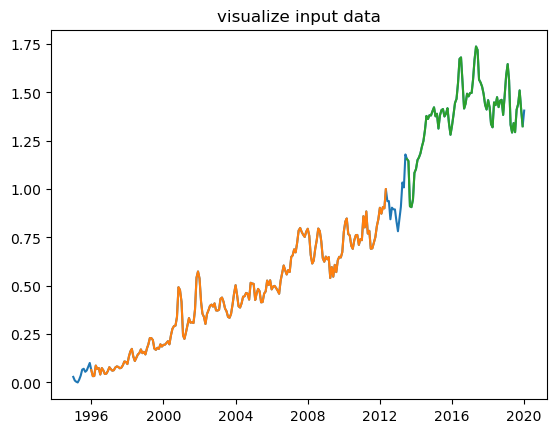

In [19]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [20]:
ar_lstm_model = AR_LSTM(
    units=256,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_lstm_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=100,
                             patience=20)


Epoch 1/100
7/7 [==============================] - 3s 139ms/step - loss: 0.1325 - mean_absolute_error: 0.2833 - val_loss: 0.5682 - val_mean_absolute_error: 0.6095
Epoch 2/100
7/7 [==============================] - 0s 43ms/step - loss: 0.0390 - mean_absolute_error: 0.1502 - val_loss: 0.6373 - val_mean_absolute_error: 0.5689
Epoch 3/100
7/7 [==============================] - 0s 41ms/step - loss: 0.0318 - mean_absolute_error: 0.1274 - val_loss: 0.6038 - val_mean_absolute_error: 0.5837
Epoch 4/100
7/7 [==============================] - 0s 43ms/step - loss: 0.0265 - mean_absolute_error: 0.1138 - val_loss: 0.4123 - val_mean_absolute_error: 0.4931
Epoch 5/100
7/7 [==============================] - 0s 57ms/step - loss: 0.0236 - mean_absolute_error: 0.1051 - val_loss: 0.4100 - val_mean_absolute_error: 0.4805
Epoch 6/100
7/7 [==============================] - 0s 45ms/step - loss: 0.0217 - mean_absolute_error: 0.1017 - val_loss: 0.4019 - val_mean_absolute_error: 0.5144
Epoch 7/100
7/7 [==========

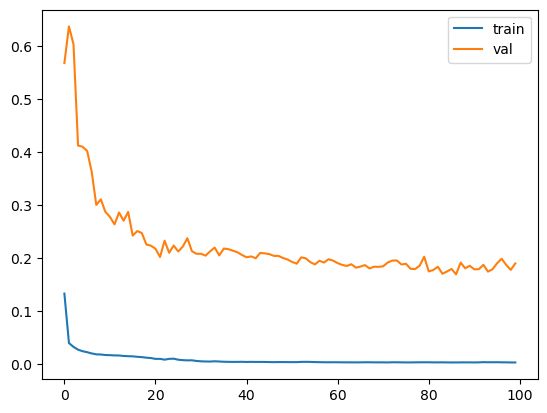

In [21]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [22]:
pred_train = ar_lstm_model.predict(X_train)  #[:, -1]
pred_test = ar_lstm_model.predict(X_test)  #[:, -1]

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])

3/3 [==============================] - 0s 11ms/step


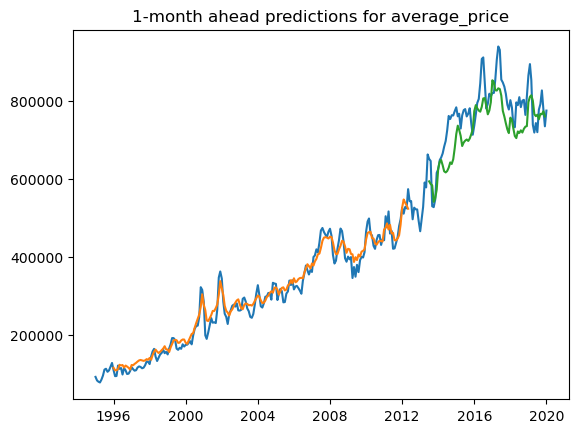

In [23]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


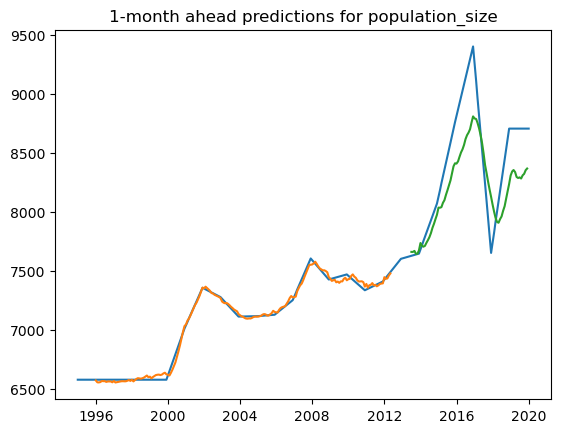

In [24]:
col_idx = 5
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


In [25]:
y_1mo_train_rescaled = scaler.inverse_transform(y_train[:, 0])
y_1mo_test_rescaled = scaler.inverse_transform(y_test[:, 0])
# y_12mo_train_rescaled = scaler.inverse_transform(y_train[:, -1])
# y_12mo_test_rescaled = scaler.inverse_transform(y_test[:, -1])

In [26]:
y_1mo_train_rescaled.shape

(197, 8)

In [27]:
print('Train 1mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_1mo_train_rescaled[:, 0],
                           y_1mo_train_rescaled[:, 0]))))
print('Test 1mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_1mo_test_rescaled[:, 0],
                           y_1mo_test_rescaled[:, 0]))))

Train 1mo RMSE: 20876.894612370786
Test 1mo RMSE: 63516.4152827992


### predict diff

#### data

In [28]:
cols = ['average_price_d1']
lookback = 12
lookforward = 1
train_df, test_df, X_train, y_train, X_test, y_test, scaler = utils.format_data_for_forecasting(
    area_data, cols, lookback, lookforward)

In [29]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(197, 12, 1)
(197, 1, 1)
(78, 12, 1)
(78, 1, 1)


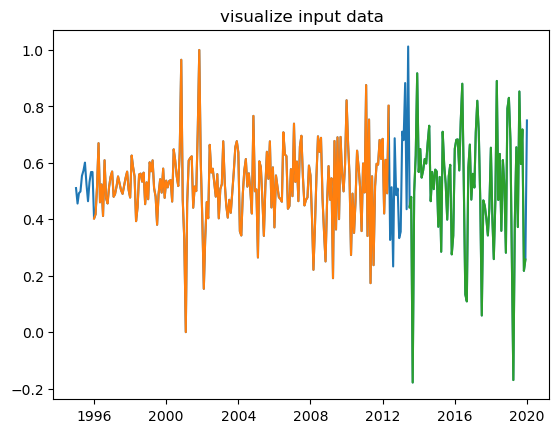

In [30]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [31]:
ar_lstm_model = AR_LSTM(
    units=64,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_lstm_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=50,
                             patience=10)


Epoch 1/50
7/7 [==============================] - 10s 781ms/step - loss: 0.1812 - mean_absolute_error: 0.4015 - val_loss: 0.0886 - val_mean_absolute_error: 0.2554
Epoch 2/50
7/7 [==============================] - 0s 33ms/step - loss: 0.0343 - mean_absolute_error: 0.1420 - val_loss: 0.0693 - val_mean_absolute_error: 0.1966
Epoch 3/50
7/7 [==============================] - 0s 35ms/step - loss: 0.0347 - mean_absolute_error: 0.1486 - val_loss: 0.0558 - val_mean_absolute_error: 0.1732
Epoch 4/50
7/7 [==============================] - 0s 33ms/step - loss: 0.0194 - mean_absolute_error: 0.1025 - val_loss: 0.0512 - val_mean_absolute_error: 0.1715
Epoch 5/50
7/7 [==============================] - 0s 32ms/step - loss: 0.0230 - mean_absolute_error: 0.1157 - val_loss: 0.0523 - val_mean_absolute_error: 0.1752
Epoch 6/50
7/7 [==============================] - 0s 38ms/step - loss: 0.0204 - mean_absolute_error: 0.1075 - val_loss: 0.0505 - val_mean_absolute_error: 0.1645
Epoch 7/50
7/7 [================

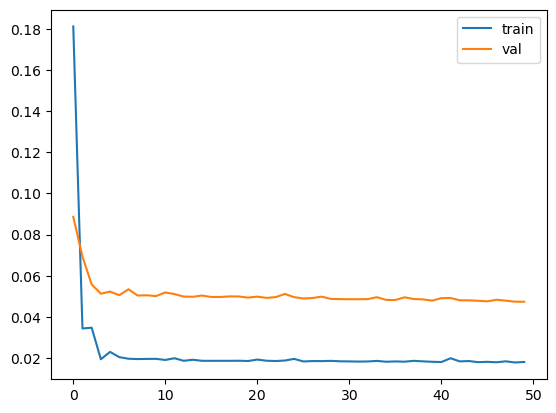

In [32]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [33]:
pred_train = ar_lstm_model.predict(X_train)  #[:, -1]
pred_test = ar_lstm_model.predict(X_test)  #[:, -1]

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])

3/3 [==============================] - 0s 5ms/step


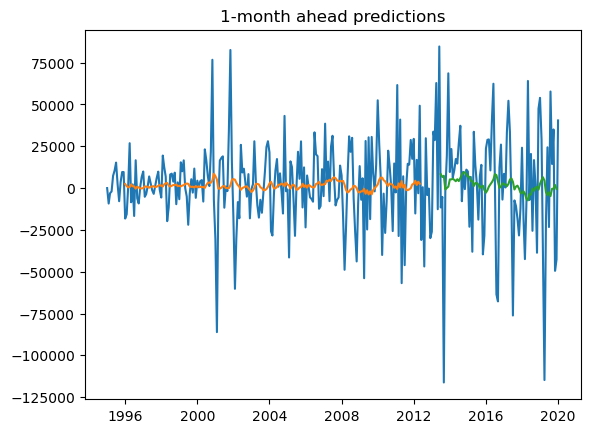

In [34]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=col_idx,
                    title='1-month ahead predictions')

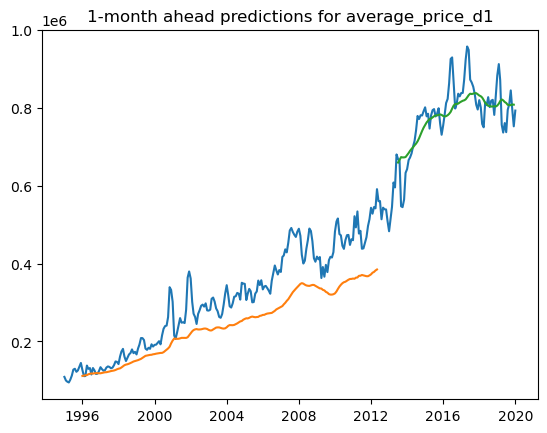

In [35]:
col_idx = 0
plot_cumulative(area_data=area_data,
                ground_truth_diff=pd.concat([train_df[cols], test_df[cols]]),
                train_ts_diff=pred_1mo_train_rescaled,
                test_ts_diff=pred_1mo_test_rescaled,
                cols=cols,
                col_idx=col_idx,
                lookback=lookback,
                lookforward=lookforward,
                fwd_offset=0,
                title=f'1-month ahead predictions for {cols[col_idx]}')


## autoregressive prediction

### predict raw

#### data setup

In [36]:
cols = ["average_price"]
lookback = 12
lookforward = 12
train_df, test_df, X_train, y_train, X_test, y_test, scaler = utils.format_data_for_forecasting(
    area_data, cols, lookback, lookforward)

In [37]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(186, 12, 1)
(186, 12, 1)
(67, 12, 1)
(67, 12, 1)


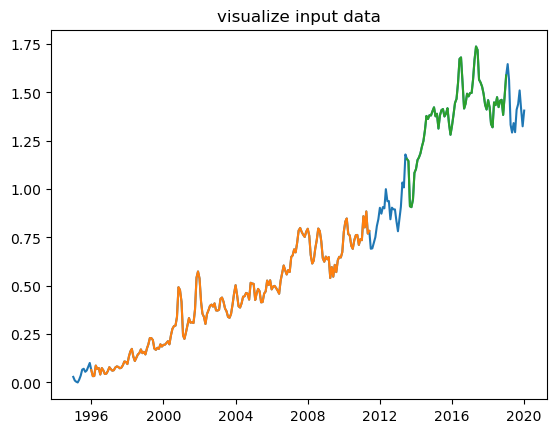

In [38]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [39]:
ar_lstm_model = AR_LSTM(
    units=64,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_lstm_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=50,
                             patience=10)


Epoch 1/50
6/6 [==============================] - 7s 237ms/step - loss: 0.1687 - mean_absolute_error: 0.3540 - val_loss: 0.7544 - val_mean_absolute_error: 0.8569
Epoch 2/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0342 - mean_absolute_error: 0.1464 - val_loss: 0.0278 - val_mean_absolute_error: 0.1339
Epoch 3/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0254 - mean_absolute_error: 0.1334 - val_loss: 0.1568 - val_mean_absolute_error: 0.3795
Epoch 4/50
6/6 [==============================] - 0s 30ms/step - loss: 0.0150 - mean_absolute_error: 0.0966 - val_loss: 0.2771 - val_mean_absolute_error: 0.5111
Epoch 5/50
6/6 [==============================] - 0s 30ms/step - loss: 0.0149 - mean_absolute_error: 0.0951 - val_loss: 0.1316 - val_mean_absolute_error: 0.3446
Epoch 6/50
6/6 [==============================] - 0s 33ms/step - loss: 0.0110 - mean_absolute_error: 0.0898 - val_loss: 0.0465 - val_mean_absolute_error: 0.1870
Epoch 7/50
6/6 [=================

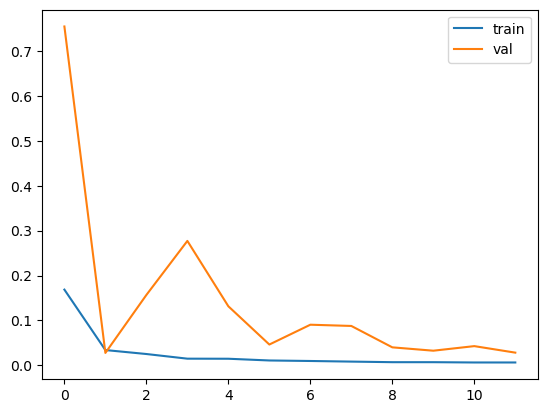

In [40]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [41]:
pred_train = ar_lstm_model.predict(X_train)  #[:, -1]
pred_test = ar_lstm_model.predict(X_test)  #[:, -1]

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])
pred_12mo_train_rescaled = scaler.inverse_transform(pred_train[:, -1])
pred_12mo_test_rescaled = scaler.inverse_transform(pred_test[:, -1])


3/3 [==============================] - 0s 8ms/step


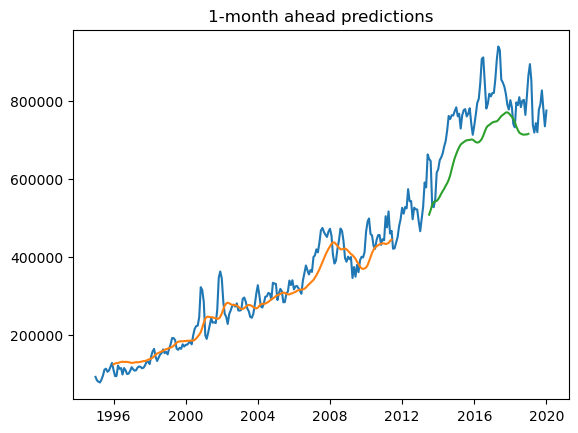

In [42]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='1-month ahead predictions')

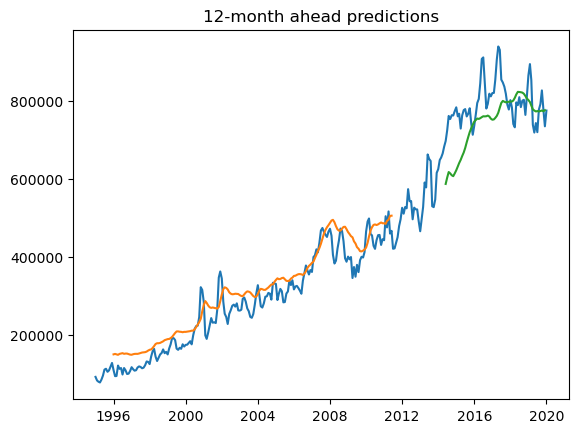

In [43]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_12mo_train_rescaled,
                    test_ts=pred_12mo_test_rescaled,
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=11,
                    title='12-month ahead predictions')


In [44]:
y_1mo_train_rescaled = scaler.inverse_transform(y_train[:, 0])
y_1mo_test_rescaled = scaler.inverse_transform(y_test[:, 0])
y_12mo_train_rescaled = scaler.inverse_transform(y_train[:, -1])
y_12mo_test_rescaled = scaler.inverse_transform(y_test[:, -1])

In [45]:
y_1mo_train_rescaled.shape

(186, 1)

In [46]:
print('Train 1mo RMSE: {}'.format(
    np.sqrt(mean_squared_error(pred_1mo_train_rescaled, y_1mo_train_rescaled))))
print('Test 1mo RMSE: {}'.format(
    np.sqrt(mean_squared_error(pred_1mo_test_rescaled, y_1mo_test_rescaled))))

print('Train 12mo RMSE: {}'.format(
    np.sqrt(mean_squared_error(pred_12mo_train_rescaled,
                               y_12mo_train_rescaled))))
print('Test 12mo RMSE: {}'.format(
    np.sqrt(mean_squared_error(pred_12mo_test_rescaled, y_12mo_test_rescaled))))


Train 1mo RMSE: 36535.87533470572
Test 1mo RMSE: 99112.99611229291
Train 12mo RMSE: 44302.623472788815
Test 12mo RMSE: 83803.39685776859


### multiple features

#### data setup

In [47]:
cols = [
    'average_price', 'year', 'month', 'average_price_d1', 'median_salary',
    'population_size', 'number_of_jobs', 'no_of_houses'
]  # w no nans

lookback = 12
lookforward = 12
train_df, test_df, X_train, y_train, X_test, y_test, scaler = utils.format_data_for_forecasting(
    area_data, cols, lookback, lookforward)

In [48]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(186, 12, 8)
(186, 12, 8)
(67, 12, 8)
(67, 12, 8)


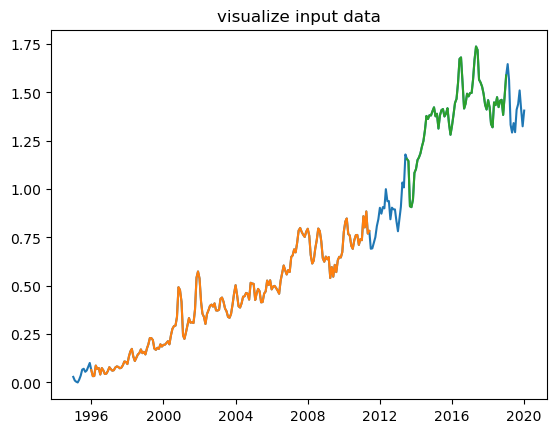

In [49]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [50]:
ar_lstm_model = AR_LSTM(
    units=256,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_lstm_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=100,
                             patience=20)


Epoch 1/100
6/6 [==============================] - 9s 335ms/step - loss: 0.1387 - mean_absolute_error: 0.2905 - val_loss: 0.8346 - val_mean_absolute_error: 0.6322
Epoch 2/100
6/6 [==============================] - 1s 123ms/step - loss: 0.0497 - mean_absolute_error: 0.1731 - val_loss: 0.8443 - val_mean_absolute_error: 0.6669
Epoch 3/100
6/6 [==============================] - 1s 105ms/step - loss: 0.0305 - mean_absolute_error: 0.1279 - val_loss: 0.7534 - val_mean_absolute_error: 0.6448
Epoch 4/100
6/6 [==============================] - 0s 84ms/step - loss: 0.0282 - mean_absolute_error: 0.1151 - val_loss: 0.7403 - val_mean_absolute_error: 0.6093
Epoch 5/100
6/6 [==============================] - 1s 93ms/step - loss: 0.0243 - mean_absolute_error: 0.1106 - val_loss: 0.7140 - val_mean_absolute_error: 0.6152
Epoch 6/100
6/6 [==============================] - 1s 107ms/step - loss: 0.0231 - mean_absolute_error: 0.1053 - val_loss: 0.7320 - val_mean_absolute_error: 0.6325
Epoch 7/100
6/6 [=======

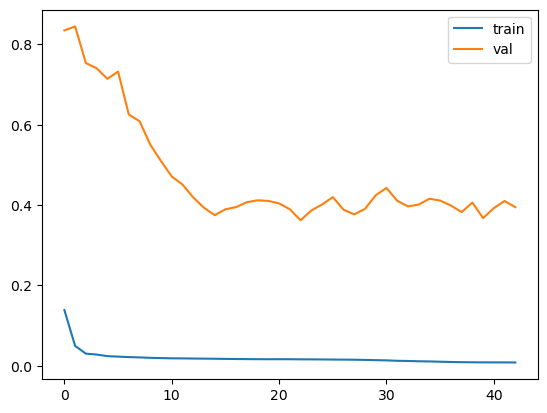

In [51]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [52]:
pred_train = ar_lstm_model.predict(X_train)  #[:, -1]
pred_test = ar_lstm_model.predict(X_test)  #[:, -1]

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])
pred_12mo_train_rescaled = scaler.inverse_transform(pred_train[:, -1])
pred_12mo_test_rescaled = scaler.inverse_transform(pred_test[:, -1])


3/3 [==============================] - 0s 17ms/step


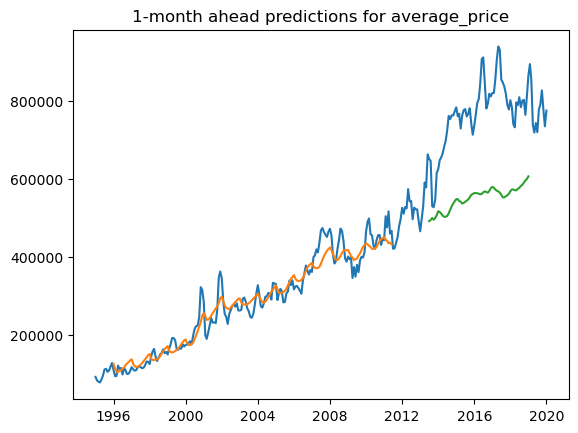

In [53]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


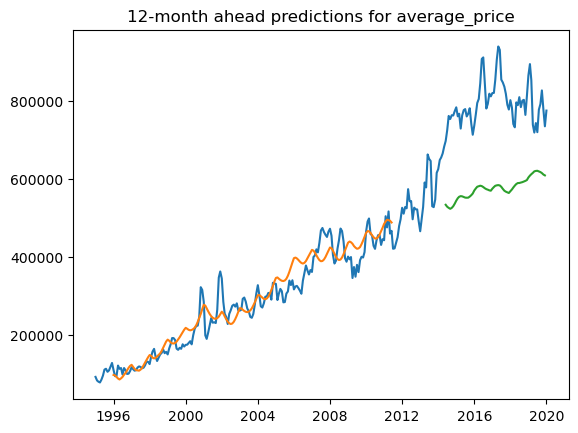

In [54]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_12mo_train_rescaled,
                    test_ts=pred_12mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=11,
                    title=f'12-month ahead predictions for {cols[col_idx]}')


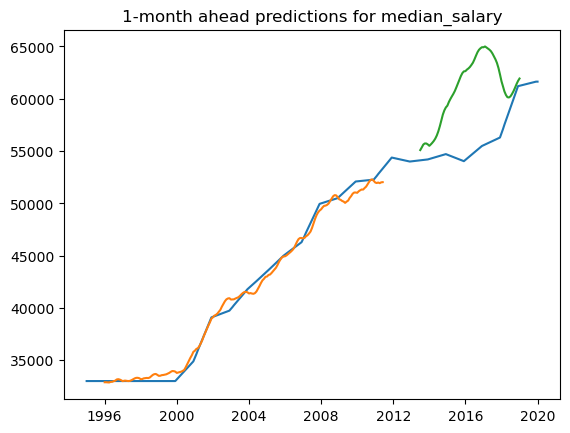

In [55]:
col_idx = 4
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


In [56]:
y_1mo_train_rescaled = scaler.inverse_transform(y_train[:, 0])
y_1mo_test_rescaled = scaler.inverse_transform(y_test[:, 0])
y_12mo_train_rescaled = scaler.inverse_transform(y_train[:, -1])
y_12mo_test_rescaled = scaler.inverse_transform(y_test[:, -1])

In [57]:
y_1mo_train_rescaled.shape

(186, 8)

In [58]:
print('Train 1mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_1mo_train_rescaled[:, 0],
                           y_1mo_train_rescaled[:, 0]))))
print('Test 1mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_1mo_test_rescaled[:, 0],
                           y_1mo_test_rescaled[:, 0]))))

print('Train 12mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_12mo_train_rescaled[:, 0],
                           y_12mo_train_rescaled[:, 0]))))
print('Test 12mo RMSE: {}'.format(
    np.sqrt(
        mean_squared_error(pred_12mo_test_rescaled[:, 0],
                           y_12mo_test_rescaled[:, 0]))))


Train 1mo RMSE: 29098.49841522268
Test 1mo RMSE: 227758.43623254457
Train 12mo RMSE: 33747.86787136168
Test 12mo RMSE: 225438.75655132663


### predict diff

#### data

In [59]:
cols = ['average_price_d1']
lookback = 12
lookforward = 12
train_df, test_df, X_train, y_train, X_test, y_test, scaler = utils.format_data_for_forecasting(
    area_data, cols, lookback, lookforward)

In [60]:
print(X_train.shape)  # (num samples, lookback time steps, features)
print(y_train.shape)  # (num samples, lookforward time steps, features)
print(X_test.shape)  # (num samples, lookback time steps, features)
print(y_test.shape)  # (num samples, lookforward time steps, features)

(186, 12, 1)
(186, 12, 1)
(67, 12, 1)
(67, 12, 1)


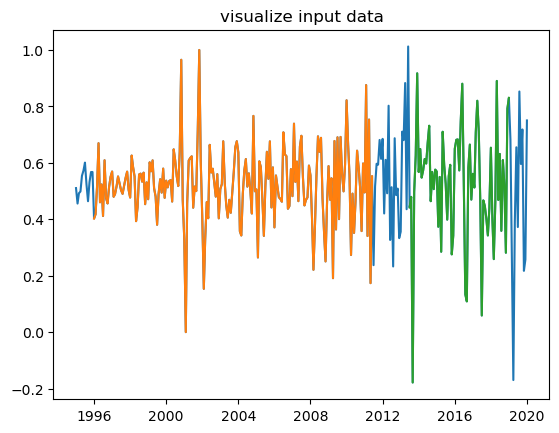

In [61]:
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=y_train[:, 0],
                    test_ts=y_test[:, 0],
                    cols=cols,
                    col_idx=0,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title='visualize input data')


#### create and train model

In [62]:
ar_lstm_model = AR_LSTM(
    units=64,  # TODO: modify this hyperparam
    lookback=lookback,
    input_fts=len(cols),
    out_steps=lookforward)  # 12 month rollout forecast
history = compile_and_fit_tf(ar_lstm_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             epochs=50,
                             patience=10)


Epoch 1/50
6/6 [==============================] - 10s 280ms/step - loss: 0.2656 - mean_absolute_error: 0.4969 - val_loss: 0.1972 - val_mean_absolute_error: 0.4087
Epoch 2/50
6/6 [==============================] - 0s 43ms/step - loss: 0.1087 - mean_absolute_error: 0.2975 - val_loss: 0.0470 - val_mean_absolute_error: 0.1731
Epoch 3/50
6/6 [==============================] - 0s 27ms/step - loss: 0.0353 - mean_absolute_error: 0.1473 - val_loss: 0.0604 - val_mean_absolute_error: 0.1877
Epoch 4/50
6/6 [==============================] - 0s 29ms/step - loss: 0.0228 - mean_absolute_error: 0.1113 - val_loss: 0.0448 - val_mean_absolute_error: 0.1673
Epoch 5/50
6/6 [==============================] - 0s 30ms/step - loss: 0.0248 - mean_absolute_error: 0.1241 - val_loss: 0.0468 - val_mean_absolute_error: 0.1725
Epoch 6/50
6/6 [==============================] - 0s 29ms/step - loss: 0.0207 - mean_absolute_error: 0.1082 - val_loss: 0.0408 - val_mean_absolute_error: 0.1528
Epoch 7/50
6/6 [================

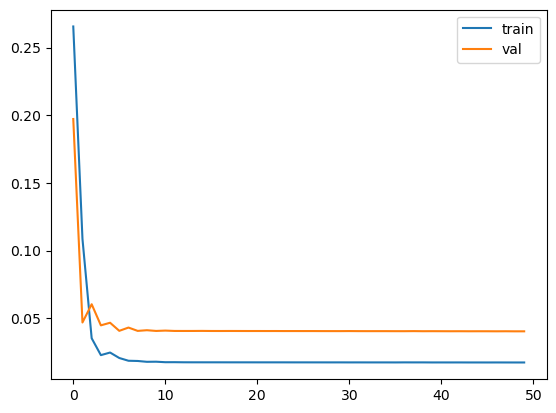

In [63]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

#### predictions

In [64]:
pred_train = ar_lstm_model.predict(X_train)  #[:, -1]
pred_test = ar_lstm_model.predict(X_test)  #[:, -1]

# revert scaling
# TODO: add to pipeline

# un-scale
train_df[cols] = scaler.inverse_transform(train_df[cols])
test_df[cols] = scaler.inverse_transform(test_df[cols])

# (num samples, lookforward time steps, features)
# [:, :, 0] is the first feature, i.e. average price
# scaling applies to all features
pred_1mo_train_rescaled = scaler.inverse_transform(pred_train[:, 0])
pred_1mo_test_rescaled = scaler.inverse_transform(pred_test[:, 0])
pred_12mo_train_rescaled = scaler.inverse_transform(pred_train[:, -1])
pred_12mo_test_rescaled = scaler.inverse_transform(pred_test[:, -1])


3/3 [==============================] - 0s 5ms/step


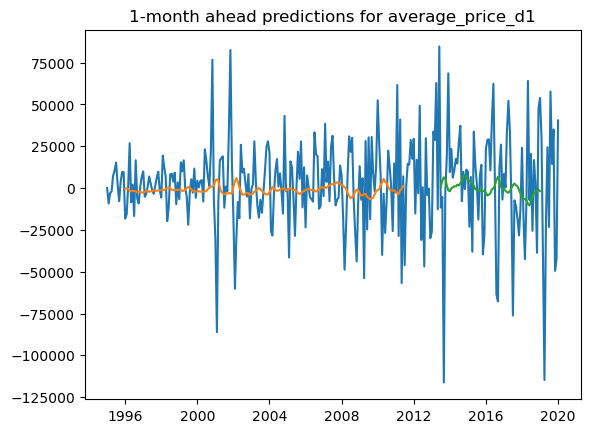

In [65]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_1mo_train_rescaled,
                    test_ts=pred_1mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=0,
                    title=f'1-month ahead predictions for {cols[col_idx]}')


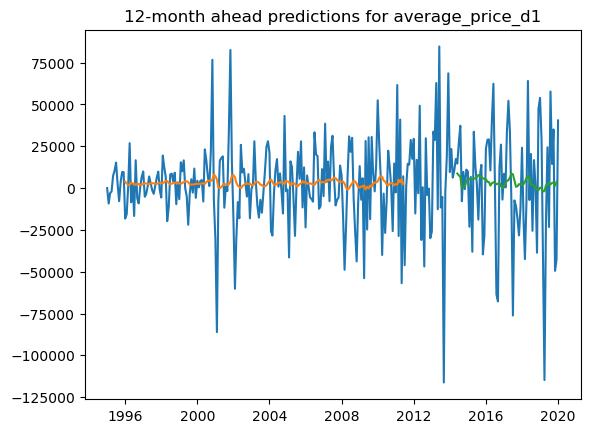

In [66]:
col_idx = 0
plot_inputs_outputs(area_data=area_data,
                    ground_truth=pd.concat([train_df[cols], test_df[cols]]),
                    train_ts=pred_12mo_train_rescaled,
                    test_ts=pred_12mo_test_rescaled,
                    cols=cols,
                    col_idx=col_idx,
                    lookback=lookback,
                    lookforward=lookforward,
                    fwd_offset=11,
                    title=f'12-month ahead predictions for {cols[col_idx]}')


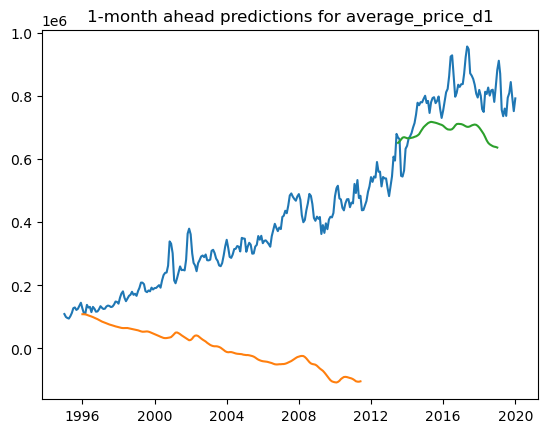

In [67]:
plot_cumulative(area_data=area_data,
                ground_truth_diff=pd.concat([train_df[cols], test_df[cols]]),
                train_ts_diff=pred_1mo_train_rescaled,
                test_ts_diff=pred_1mo_test_rescaled,
                cols=cols,
                col_idx=col_idx,
                lookback=lookback,
                lookforward=lookforward,
                fwd_offset=0,
                title=f'1-month ahead predictions for {cols[col_idx]}')


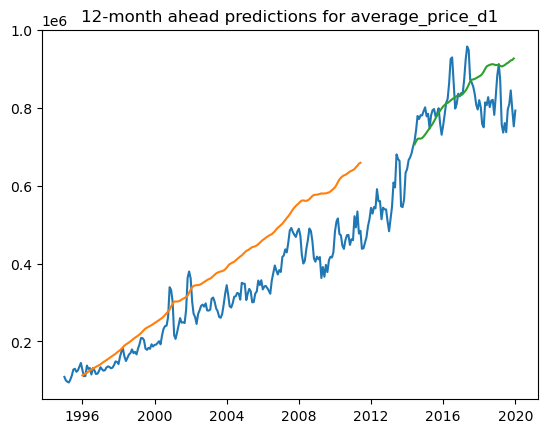

In [68]:
plot_cumulative(area_data=area_data,
                ground_truth_diff=pd.concat([train_df[cols], test_df[cols]]),
                train_ts_diff=pred_12mo_train_rescaled,
                test_ts_diff=pred_12mo_test_rescaled,
                cols=cols,
                col_idx=col_idx,
                lookback=lookback,
                lookforward=lookforward,
                fwd_offset=11,
                title=f'12-month ahead predictions for {cols[col_idx]}')
